In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle, os

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Dropout, Bidirectional

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import *

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import seaborn as sns

In [2]:
VERSION = 'v1'

In [3]:
df = pd.read_csv('../../dataset/csv/dataset_v1.csv')
df.head(3)


,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,y74,z74,v74,x75,y75,z75,v75,face_d75,face_s75,hand_s75
0,celinguk,0.452516,0.177898,-0.904605,0.999882,0.516650,0.137372,-0.673349,0.999341,0.422173,...,0.609458,-0.498302,0.967000,0.330829,0.609458,-0.498302,0.967000,2.0,0.0,0.0
1,celinguk,0.687073,0.188956,-0.612002,0.996062,0.648438,0.158911,-0.388706,0.987777,0.601190,...,0.525487,-0.142604,0.941713,0.311903,0.525487,-0.142604,0.941713,0.0,0.0,0.0
2,celinguk,0.485780,0.217672,-0.780860,0.996510,0.578979,0.168560,-0.718592,0.986905,0.490544,...,0.577168,-0.192743,0.966556,0.330957,0.577168,-0.192743,0.966556,2.0,0.0,0.0


In [4]:
df['class'].value_counts()



class
celinguk       50
diam           50
nodong         50
tutupmuka      50
tutuptangan    50
Name: count, dtype: int64

In [5]:
X = df.drop('class', axis=1) # features
y = df['class'] # target value

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1234)

print(f"Train set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
y_test

Train set size: 212
Test set size: 38


202    tutuptangan
94            diam
31        celinguk
246    tutuptangan
215    tutuptangan
6         celinguk
91            diam
73            diam
129         nodong
5         celinguk
136         nodong
111         nodong
161      tutupmuka
74            diam
48        celinguk
65            diam
7         celinguk
218    tutuptangan
32        celinguk
63            diam
132         nodong
97            diam
51            diam
122         nodong
9         celinguk
145         nodong
110         nodong
196      tutupmuka
52            diam
238    tutuptangan
29        celinguk
131         nodong
125         nodong
141         nodong
235    tutuptangan
164      tutupmuka
245    tutuptangan
95            diam
Name: class, dtype: object

# Training Model : LSTM SINGLE

In [6]:
# Separate features (X) and labels (y)
X_raw = df.iloc[:, 1:].values
y_raw = df['class'].values

# Encode Labels (for multi-class classification)
# Assuming 'diam' is just one class and there might be others in a full dataset
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
N_CLASSES = len(label_encoder.classes_)

# Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

In [7]:
# Reshape for LSTM (Single Timestep) ---
# Format: [samples, timesteps, features]
N_SAMPLES = X_scaled.shape[0]
N_FEATURES_PER_SAMPLE = X_scaled.shape[1]
N_TIMESTEPS = 1 # Each row is treated as one observation with one timestep

X_reshaped = X_scaled.reshape(N_SAMPLES, N_TIMESTEPS, N_FEATURES_PER_SAMPLE)

In [8]:
if N_CLASSES > 2:
    y_final = tf.keras.utils.to_categorical(y_encoded, num_classes=N_CLASSES)
    loss_fn = 'categorical_crossentropy'
    output_activation = 'softmax'
else:
    # If it's effectively binary (N_CLASSES=2), we still use sparse_categorical_crossentropy 
    # since we kept y_encoded as integer labels
    y_final = y_encoded
    loss_fn = 'sparse_categorical_crossentropy'
    # If N_CLASSES=2, the Dense layer should have 1 unit with 'sigmoid' for binary_crossentropy
    # or N_CLASSES units with 'softmax' for categorical_crossentropy. 
    # Since we use sparse_categorical_crossentropy with integer labels, N_CLASSES with 'softmax' is safest.
    output_activation = 'softmax'

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_final, test_size=0.2, random_state=42, stratify=y_final
)

In [10]:
lstm_model = Sequential([
    # Single LSTM Layer (no return_sequences since it's the last recurrent layer)
    LSTM(units=128, activation='relu', input_shape=(N_TIMESTEPS, N_FEATURES_PER_SAMPLE)),
    Dropout(0.3),
    # Output Dense layer
    Dense(units=N_CLASSES, activation=output_activation)
])

d:\Project Coding\Research\suspicious_detection\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
KERAS_MODEL_FILENAME = f'../../model/trained/lstm_s/single_lstm_weights_{VERSION}.best.keras'

checkpoint_cb = ModelCheckpoint(
    filepath=KERAS_MODEL_FILENAME, 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,   
    restore_best_weights=True, 
    mode='min',
    verbose=1
)

lstm_model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

print(f"\nModel Input Shape: {X_train.shape[1:]}")
print(f"Model Output Classes: {N_CLASSES}")
print("-" * 30)
lstm_model.summary()
print("-" * 30)

# Training (using the split training data)
print("Starting Model Training...")
history_lstm = lstm_model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=4,
    verbose=0,
    validation_split=0.2,
    callbacks=[checkpoint_cb, earlystop_cb]
)
print("Model Training Complete.")
print("-" * 30)


Model Input Shape: (1, 345)
Model Output Classes: 5
------------------------------


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       242,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,333 (950.52 KB)

 Trainable params: 243,333 (950.52 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------
Starting Model Training...

Epoch 1: val_loss improved from None to 0.37943, saving model to ../../model/trained/lstm_s/single_lstm_weights_v1.best.keras

Epoch 2: val_loss improved from 0.37943 to 0.27730, saving model to ../../model/trained/lstm_s/single_lstm_weights_v1.best.keras

Epoch 3: val_loss improved from 0.27730 to 0.13556, saving model to ../../model/trained/lstm_s/single_lstm_weights_v1.best.keras

Epoch 4: val_loss did not improve from 0.13556

Epoch 5: val_loss did not improve from 0.13556

Epoch 6: val_loss did not improve from 0.13556

Epoch 7: val_loss did not improve from 0.13556

Epoch 8: val_loss improved from 0.13556 to 0.04608, saving model to ../../model/trained/lstm_s/single_lstm_weights_v1.best.keras

Epoch 9: val_loss did not improve from 0.04608

Epoch 10: val_loss improved from 0.04608 to 0.04246, saving model to ../../model/trained/lstm_s/single_lstm_weights_v1.best.keras

Epoch 11: val_loss improved from 0.04246 to 0.02736, 

In [12]:
# Since TensorFlow models don't pickle reliably, we save the trained 
# Keras model separately and then pickle a dictionary containing the necessary 
# preprocessing objects.

PICKLE_FILENAME = f'lstm_model_{VERSION}.pkl'
KERAS_MODEL_FILENAME = f'../../model/trained/lstm_s/single_lstm_weights_{VERSION}.keras'

# 8a. Save the Keras model in its native format
lstm_model.save(KERAS_MODEL_FILENAME)

# 8b. Create a dictionary of necessary artifacts
artifacts = {
    'scaler': scaler,
    'label_encoder': label_encoder,
    'model_filename': KERAS_MODEL_FILENAME,
    'input_shape': X_train.shape[1:],
    'num_classes': N_CLASSES
}

# 8c. Pickle the artifacts dictionary
with open(f'../../model/trained/lstm_s/{PICKLE_FILENAME}', 'wb') as file:
    pickle.dump(artifacts, file)

print(f"Preprocessing artifacts (Scaler, Encoder) saved to: {PICKLE_FILENAME}")
print(f"Trained Keras model weights saved to: {KERAS_MODEL_FILENAME}")
print("\nTo load and use this model, you'll need both files and the TensorFlow code to load the .keras file.")

Preprocessing artifacts (Scaler, Encoder) saved to: lstm_model_v1.pkl
Trained Keras model weights saved to: ../../model/trained/lstm_s/single_lstm_weights_v1.keras

To load and use this model, you'll need both files and the TensorFlow code to load the .keras file.


# BILSTM : Training Model

In [14]:
bilstm_model = Sequential([
    # Bi-LSTM Layer: Wrap LSTM in Bidirectional
    Bidirectional(LSTM(
        units=128,          # Number of units for EACH direction (Forward and Backward)
        activation='relu'
    ), input_shape=(N_TIMESTEPS, N_FEATURES_PER_SAMPLE)),
    
    Dropout(0.3),
    
    # Dense layers for classification
    Dense(units=64, activation='relu'),
    Dense(units=N_CLASSES, activation=output_activation)
])

d:\Project Coding\Research\suspicious_detection\venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
KERAS_MODEL_FILENAME = f'../../model/trained/lstm_bi/bi_lstm_weights_{VERSION}.best.keras'

checkpoint_cb = ModelCheckpoint(
    filepath=KERAS_MODEL_FILENAME, 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,   
    restore_best_weights=True, 
    mode='min',
    verbose=1
)

bilstm_model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

print(f"Model Input Shape: {X_train.shape[1:]}")
print(f"Model Output Classes: {N_CLASSES}")
print("-" * 50)
bilstm_model.summary()
print("-" * 50)

print("Starting BiLSTM Model Training...")
# Train the model
history_bilstm = bilstm_model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=4,
    validation_split=0.2,
    verbose=0,
    callbacks=[checkpoint_cb, earlystop_cb]
)
print("Model Training Complete.")
print("-" * 50)

# Evaluate the model
loss, accuracy = bilstm_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print("-" * 50)

Model Input Shape: (1, 345)
Model Output Classes: 5
--------------------------------------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 256)            │       485,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 502,149 (1.92 MB)

 Trainable params: 502,149 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

--------------------------------------------------
Starting BiLSTM Model Training...

Epoch 1: val_loss improved from None to 0.45911, saving model to ../../model/trained/lstm_bi/bi_lstm_weights_v1.best.keras

Epoch 2: val_loss improved from 0.45911 to 0.18203, saving model to ../../model/trained/lstm_bi/bi_lstm_weights_v1.best.keras

Epoch 3: val_loss improved from 0.18203 to 0.10224, saving model to ../../model/trained/lstm_bi/bi_lstm_weights_v1.best.keras

Epoch 4: val_loss did not improve from 0.10224

Epoch 5: val_loss did not improve from 0.10224

Epoch 6: val_loss did not improve from 0.10224

Epoch 7: val_loss did not improve from 0.10224

Epoch 8: val_loss improved from 0.10224 to 0.02610, saving model to ../../model/trained/lstm_bi/bi_lstm_weights_v1.best.keras

Epoch 9: val_loss did not improve from 0.02610

Epoch 10: val_loss did not improve from 0.02610

Epoch 11: val_loss did not improve from 0.02610

Epoch 12: val_loss did not improve from 0.02610

Epoch 13: val_loss did

In [16]:

PICKLE_FILENAME = f'bi_lstm_model_{VERSION}.pkl'
KERAS_MODEL_FILENAME = f'bi_lstm_weights_{VERSION}.keras'# Recommended native Keras format

# 4a. Save the Keras model in its native format
bilstm_model.save(f'../../model/trained/lstm_bi/{KERAS_MODEL_FILENAME}')

# 4b. Create a dictionary of necessary artifacts (Scaler, Encoder, Model Path)
artifacts = {
    'scaler': scaler,
    'label_encoder': label_encoder,
    'model_filename': KERAS_MODEL_FILENAME,
    'input_shape': X_train.shape[1:],
    'num_classes': N_CLASSES
}

# 4c. Pickle the artifacts dictionary
with open(f'../../model/trained/lstm_bi/{PICKLE_FILENAME}', 'wb') as file:
    pickle.dump(artifacts, file)

print(f"✅ BiLSTM Keras model weights saved to: {KERAS_MODEL_FILENAME}")
print(f"✅ Preprocessing artifacts (Scaler, Encoder) saved to: {PICKLE_FILENAME}")

✅ BiLSTM Keras model weights saved to: bi_lstm_weights_v1.keras
✅ Preprocessing artifacts (Scaler, Encoder) saved to: bi_lstm_model_v1.pkl


# GRU : Training Model

In [17]:
# --- 2. Define the Single-Layer GRU Model ---
gru_model = Sequential([
    # GRU Layer - No Bidirectional wrapper requested, so it's unidirectional.
    GRU(
        units=128,          # Number of units in the GRU
        activation='tanh',  # GRU default activation
        input_shape=(N_TIMESTEPS, N_FEATURES_PER_SAMPLE)
    ),
    
    Dropout(0.3),
    
    # Dense layers for classification
    Dense(units=64, activation='relu'),
    Dense(units=N_CLASSES, activation=output_activation)
])

In [18]:
KERAS_MODEL_FILENAME = f'../../model/trained/gru/gru_weights_{VERSION}.keras'

checkpoint_cb = ModelCheckpoint(
    filepath=KERAS_MODEL_FILENAME, 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,   
    restore_best_weights=True, 
    mode='min',
    verbose=1
)

gru_model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

print(f"Model Input Shape: {X_train.shape[1:]}")
print(f"Model Output Classes: {N_CLASSES}")
print("-" * 50)
gru_model.summary()
print("-" * 50)

print("Starting GRU Model Training...")
# Train the model
history_gru = gru_model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=4,
    validation_split=0.2,
    verbose=0,
    callbacks=[checkpoint_cb, earlystop_cb]
)
print("Model Training Complete.")
print("-" * 50)

# Evaluate the model
loss, accuracy = gru_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print("-" * 50)

Model Input Shape: (1, 345)
Model Output Classes: 5
--------------------------------------------------


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │       182,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,981 (746.02 KB)

 Trainable params: 190,981 (746.02 KB)

 Non-trainable params: 0 (0.00 B)

--------------------------------------------------
Starting GRU Model Training...

Epoch 1: val_loss improved from None to 0.46125, saving model to ../../model/trained/gru/gru_weights_v1.keras

Epoch 2: val_loss improved from 0.46125 to 0.26252, saving model to ../../model/trained/gru/gru_weights_v1.keras

Epoch 3: val_loss improved from 0.26252 to 0.18313, saving model to ../../model/trained/gru/gru_weights_v1.keras

Epoch 4: val_loss improved from 0.18313 to 0.12231, saving model to ../../model/trained/gru/gru_weights_v1.keras

Epoch 5: val_loss improved from 0.12231 to 0.12165, saving model to ../../model/trained/gru/gru_weights_v1.keras

Epoch 6: val_loss did not improve from 0.12165

Epoch 7: val_loss improved from 0.12165 to 0.11593, saving model to ../../model/trained/gru/gru_weights_v1.keras

Epoch 8: val_loss improved from 0.11593 to 0.07074, saving model to ../../model/trained/gru/gru_weights_v1.keras

Epoch 9: val_loss improved from 0.07074 to 0.03612, saving model to ../../

In [19]:

PICKLE_FILENAME = f'gru_model_{VERSION}.pkl'
KERAS_MODEL_FILENAME = f'gru_weights_{VERSION}.keras'# Recommended native Keras format

# 4a. Save the Keras model in its native format
gru_model.save(f'../../model/trained/gru/{KERAS_MODEL_FILENAME}')

# 4b. Create a dictionary of necessary artifacts (Scaler, Encoder, Model Path)
artifacts = {
    'scaler': scaler,
    'label_encoder': label_encoder,
    'model_filename': KERAS_MODEL_FILENAME,
    'input_shape': X_train.shape[1:],
    'num_classes': N_CLASSES
}

# 4c. Pickle the artifacts dictionary
with open(f'../../model/trained/gru/{PICKLE_FILENAME}', 'wb') as file:
    pickle.dump(artifacts, file)

print(f"✅ GRU Keras model weights saved to: {KERAS_MODEL_FILENAME}")
print(f"✅ Preprocessing artifacts (Scaler, Encoder) saved to: {PICKLE_FILENAME}")

✅ GRU Keras model weights saved to: gru_weights_v1.keras
✅ Preprocessing artifacts (Scaler, Encoder) saved to: gru_model_v1.pkl


# NN : Training Model

In [20]:
# --- Configuration ---

# Label Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
N_CLASSES = len(label_encoder.classes_)

# Scaling (Crucial for Dense layers)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

N_FEATURES_PER_SAMPLE = X_scaled.shape[1]
N_SAMPLES = X_scaled.shape[0]

# Note: MLP/Dense layers expect 2D data: [samples, features]
# We use X_scaled directly, NOT the 3D X_reshaped used for LSTMs/GRUs.
X_flat = X_scaled

# Final Output Preparation (Using sparse labels with softmax for consistency)
y_final = y_encoded
loss_fn = 'sparse_categorical_crossentropy'
output_activation = 'softmax'

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_final, test_size=0.2, random_state=42, stratify=y_final
)

In [21]:
nn_model = Sequential([
    # Input layer and first Hidden Dense Layer
    Dense(units=256, activation='relu', input_shape=(N_FEATURES_PER_SAMPLE,)),
    Dropout(0.3),
    
    # Second Hidden Dense Layer
    Dense(units=128, activation='relu'),
    Dropout(0.3),
    
    # Output Dense layer (units = number of classes, activation = softmax for classification)
    Dense(units=N_CLASSES, activation=output_activation)
])

d:\Project Coding\Research\suspicious_detection\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
KERAS_MODEL_FILENAME = f'../../model/trained/nn/nn_weights_{VERSION}.keras'

checkpoint_cb = ModelCheckpoint(
    filepath=KERAS_MODEL_FILENAME, 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,   
    restore_best_weights=True, 
    mode='min',
    verbose=1
)

nn_model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

print(f"Model Input Shape (NN/MLP): {X_train.shape[1]}")
print(f"Model Output Classes: {N_CLASSES}")
print("-" * 50)
nn_model.summary()
print("-" * 50)

print("Starting MLP Model Training...")
# Train the model
history_nn = nn_model.fit(
    X_train,
    y_train,
    epochs=30, # Use more epochs than RNNs, as simple layers train faster
    batch_size=4,
    validation_split=0.2,
    verbose=0,
    callbacks=[earlystop_cb, checkpoint_cb]
)
print("Model Training Complete.")
print("-" * 50)

# Evaluate the model
loss, accuracy = nn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print("-" * 50)

Model Input Shape (NN/MLP): 345
Model Output Classes: 5
--------------------------------------------------


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │        88,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,117 (477.02 KB)

 Trainable params: 122,117 (477.02 KB)

 Non-trainable params: 0 (0.00 B)

--------------------------------------------------
Starting MLP Model Training...

Epoch 1: val_loss improved from None to 0.26799, saving model to ../../model/trained/nn/nn_weights_v1.keras

Epoch 2: val_loss did not improve from 0.26799

Epoch 3: val_loss improved from 0.26799 to 0.12464, saving model to ../../model/trained/nn/nn_weights_v1.keras

Epoch 4: val_loss did not improve from 0.12464

Epoch 5: val_loss did not improve from 0.12464

Epoch 6: val_loss improved from 0.12464 to 0.07775, saving model to ../../model/trained/nn/nn_weights_v1.keras

Epoch 7: val_loss did not improve from 0.07775

Epoch 8: val_loss did not improve from 0.07775

Epoch 9: val_loss improved from 0.07775 to 0.03541, saving model to ../../model/trained/nn/nn_weights_v1.keras

Epoch 10: val_loss did not improve from 0.03541

Epoch 11: val_loss improved from 0.03541 to 0.03218, saving model to ../../model/trained/nn/nn_weights_v1.keras

Epoch 12: val_loss improved from 0.03218 to 0.02267, saving model to .

In [23]:

PICKLE_FILENAME = f'nn_model_{VERSION}.pkl'
KERAS_MODEL_FILENAME = f'nn_weights_{VERSION}.keras'# Recommended native Keras format

# 4a. Save the Keras model in its native format
nn_model.save(f'../../model/trained/nn/{KERAS_MODEL_FILENAME}')

# 4b. Create a dictionary of necessary artifacts (Scaler, Encoder, Model Path)
artifacts = {
    'scaler': scaler,
    'label_encoder': label_encoder,
    'model_filename': KERAS_MODEL_FILENAME,
    'input_shape': X_train.shape[1:],
    'num_classes': N_CLASSES
}

# 4c. Pickle the artifacts dictionary
with open(f'../../model/trained/nn/{PICKLE_FILENAME}', 'wb') as file:
    pickle.dump(artifacts, file)

print(f"✅ NN Keras model weights saved to: {KERAS_MODEL_FILENAME}")
print(f"✅ Preprocessing artifacts (Scaler, Encoder) saved to: {PICKLE_FILENAME}")

✅ NN Keras model weights saved to: nn_weights_v1.keras
✅ Preprocessing artifacts (Scaler, Encoder) saved to: nn_model_v1.pkl


# Visualization

In [24]:
def plot_training_history(history, title):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    

def evaluate_model(model, X_test, y_test, title, label_encoder=label_encoder):
    print(f"\n{'='*60}")
    print(f"{title} - Evaluation Results")
    print("="*60)

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {accuracy*100:.2f}%")

    y_pred = model.predict(X_test, verbose=0)

    if y_test.ndim > 1 and y_test.shape[1] > 1:
        y_true = np.argmax(y_test, axis=1)
    else:
        y_true = y_test

    y_pred_classes = np.argmax(y_pred, axis=1)

    if label_encoder is not None:
        y_true_labels = label_encoder.inverse_transform(y_true)
        y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
        target_names = label_encoder.classes_
    else:
        y_true_labels = y_true
        y_pred_labels = y_pred_classes
        target_names = None

    print("\nClassification Report:")
    print(classification_report(y_true_labels, y_pred_labels, digits=4))

    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=target_names)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = (cm / cm_sum.astype(float)) * 100

    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ""
            else:
                annot[i, j] = f"{c}\n({p:.1f}%)"

    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=True,
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'{title} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

## LSTM

In [26]:
X_raw = df.iloc[:, 1:].values
y_raw = df['class'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
N_CLASSES = len(label_encoder.classes_)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

N_SAMPLES = X_scaled.shape[0]
N_FEATURES_PER_SAMPLE = X_scaled.shape[1]
N_TIMESTEPS = 1

X_reshaped = X_scaled.reshape(N_SAMPLES, N_TIMESTEPS, N_FEATURES_PER_SAMPLE)

if N_CLASSES > 2:
    y_final = tf.keras.utils.to_categorical(y_encoded, num_classes=N_CLASSES)
    loss_fn = 'categorical_crossentropy'
    output_activation = 'softmax'
else:
    y_final = y_encoded
    loss_fn = 'sparse_categorical_crossentropy'
    output_activation = 'softmax'

X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_final, test_size=0.2, random_state=42, stratify=y_final
)

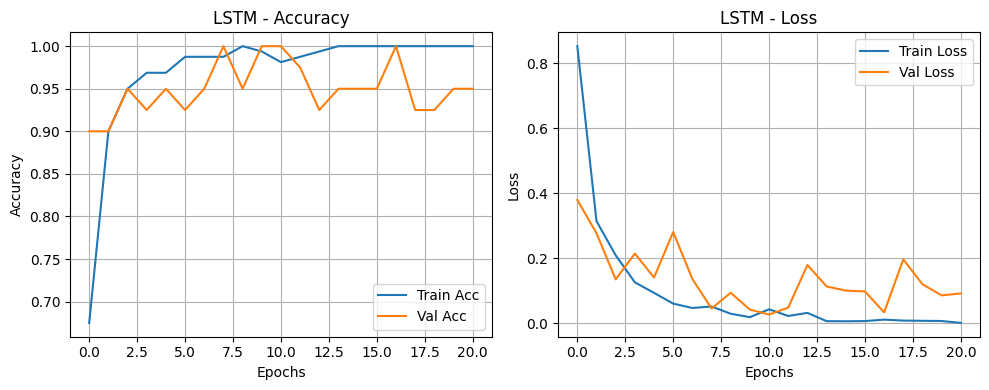

In [25]:
plot_training_history(history_lstm, "LSTM")


LSTM - Evaluation Results
Test Accuracy: 98.00%

Classification Report:
              precision    recall  f1-score   support

    celinguk     1.0000    1.0000    1.0000        10
        diam     0.9091    1.0000    0.9524        10
      nodong     1.0000    0.9000    0.9474        10
   tutupmuka     1.0000    1.0000    1.0000        10
 tutuptangan     1.0000    1.0000    1.0000        10

    accuracy                         0.9800        50
   macro avg     0.9818    0.9800    0.9799        50
weighted avg     0.9818    0.9800    0.9799        50



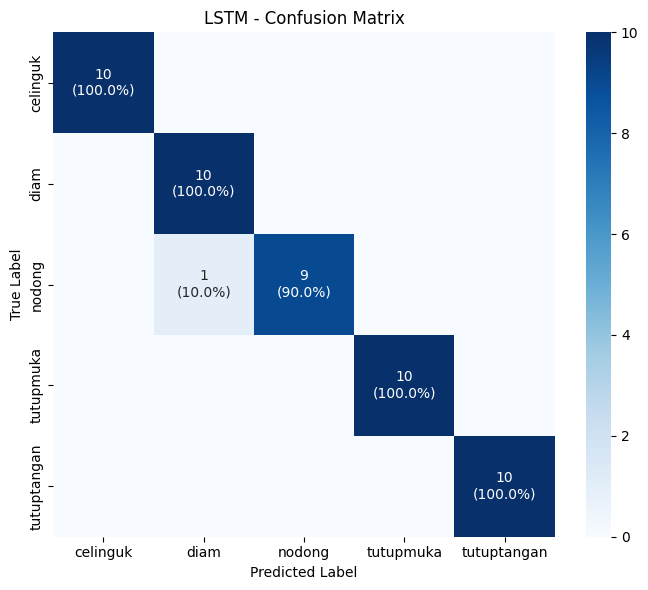

In [27]:
evaluate_model(lstm_model, X_test, y_test, "LSTM")

## BI-LSTM

In [29]:
X_raw = df.iloc[:, 1:].values
y_raw = df['class'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
N_CLASSES = len(label_encoder.classes_)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

N_SAMPLES = X_scaled.shape[0]
N_FEATURES_PER_SAMPLE = X_scaled.shape[1]
N_TIMESTEPS = 1

X_reshaped = X_scaled.reshape(N_SAMPLES, N_TIMESTEPS, N_FEATURES_PER_SAMPLE)

if N_CLASSES > 2:
    y_final = tf.keras.utils.to_categorical(y_encoded, num_classes=N_CLASSES)
    loss_fn = 'categorical_crossentropy'
    output_activation = 'softmax'
else:
    y_final = y_encoded
    loss_fn = 'sparse_categorical_crossentropy'
    output_activation = 'softmax'

X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_final, test_size=0.2, random_state=42, stratify=y_final
)

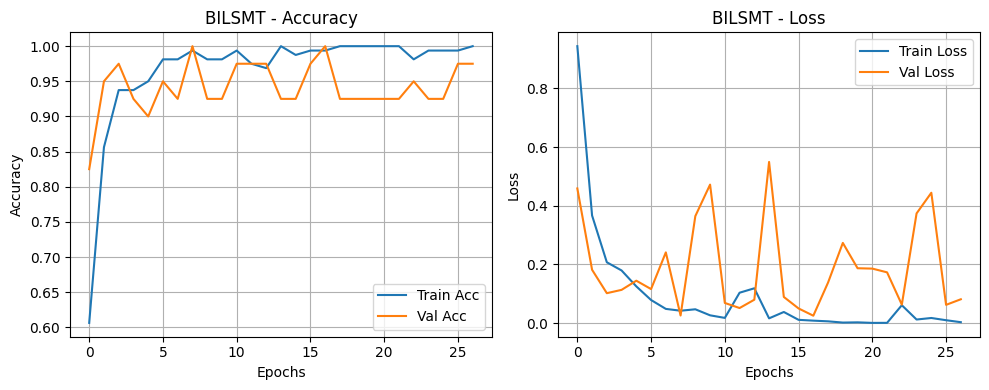

In [31]:
plot_training_history(history_bilstm, "BILSMT")


BI-LSTM - Evaluation Results
Test Accuracy: 98.00%

Classification Report:
              precision    recall  f1-score   support

    celinguk     1.0000    1.0000    1.0000        10
        diam     0.9091    1.0000    0.9524        10
      nodong     1.0000    0.9000    0.9474        10
   tutupmuka     1.0000    1.0000    1.0000        10
 tutuptangan     1.0000    1.0000    1.0000        10

    accuracy                         0.9800        50
   macro avg     0.9818    0.9800    0.9799        50
weighted avg     0.9818    0.9800    0.9799        50



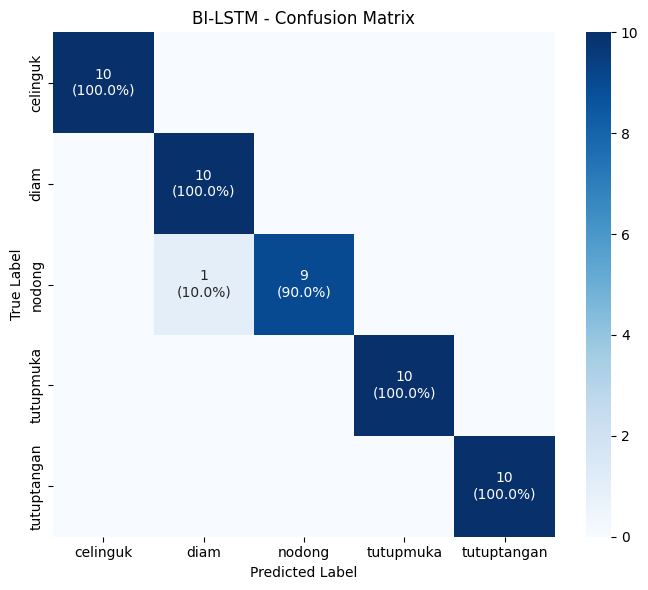

In [30]:
evaluate_model(bilstm_model, X_test, y_test, "BI-LSTM")

## GRU

In [32]:
X_raw = df.iloc[:, 1:].values
y_raw = df['class'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
N_CLASSES = len(label_encoder.classes_)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

N_SAMPLES = X_scaled.shape[0]
N_FEATURES_PER_SAMPLE = X_scaled.shape[1]
N_TIMESTEPS = 1

X_reshaped = X_scaled.reshape(N_SAMPLES, N_TIMESTEPS, N_FEATURES_PER_SAMPLE)

if N_CLASSES > 2:
    y_final = tf.keras.utils.to_categorical(y_encoded, num_classes=N_CLASSES)
    loss_fn = 'categorical_crossentropy'
    output_activation = 'softmax'
else:
    y_final = y_encoded
    loss_fn = 'sparse_categorical_crossentropy'
    output_activation = 'softmax'

X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_final, test_size=0.2, random_state=42, stratify=y_final
)

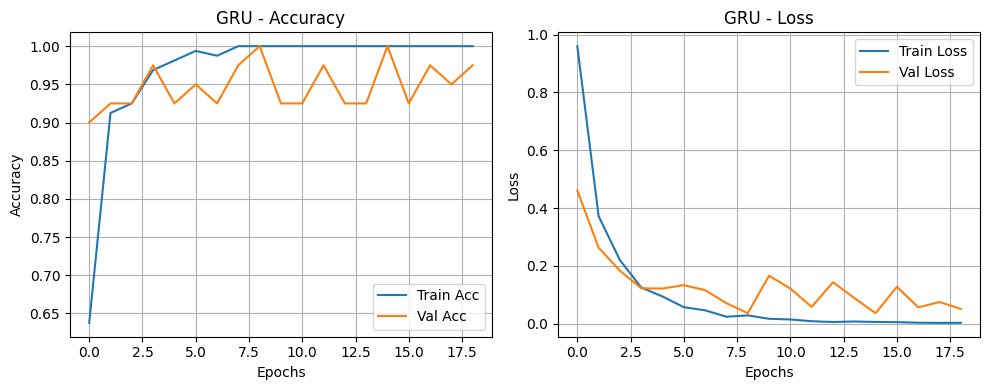

In [33]:
plot_training_history(history_gru, "GRU")


GRU - Evaluation Results
Test Accuracy: 96.00%

Classification Report:
              precision    recall  f1-score   support

    celinguk     0.9091    1.0000    0.9524        10
        diam     0.9000    0.9000    0.9000        10
      nodong     1.0000    0.9000    0.9474        10
   tutupmuka     1.0000    1.0000    1.0000        10
 tutuptangan     1.0000    1.0000    1.0000        10

    accuracy                         0.9600        50
   macro avg     0.9618    0.9600    0.9599        50
weighted avg     0.9618    0.9600    0.9599        50



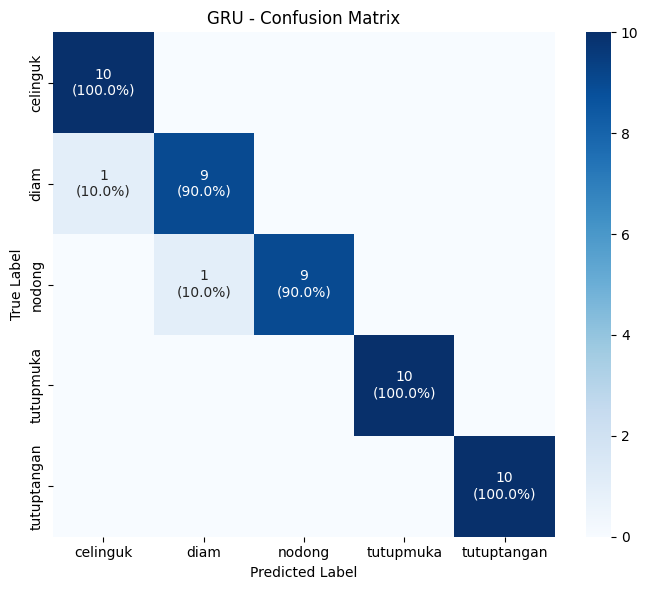

In [34]:
evaluate_model(gru_model, X_test, y_test, "GRU")

## NN

In [36]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
N_CLASSES = len(label_encoder.classes_)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

N_FEATURES_PER_SAMPLE = X_scaled.shape[1]
N_SAMPLES = X_scaled.shape[0]

X_flat = X_scaled

y_final = y_encoded
loss_fn = 'sparse_categorical_crossentropy'
output_activation = 'softmax'

X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_final, test_size=0.2, random_state=42, stratify=y_final
)

X_train = X_train.squeeze()
X_test = X_test.squeeze()

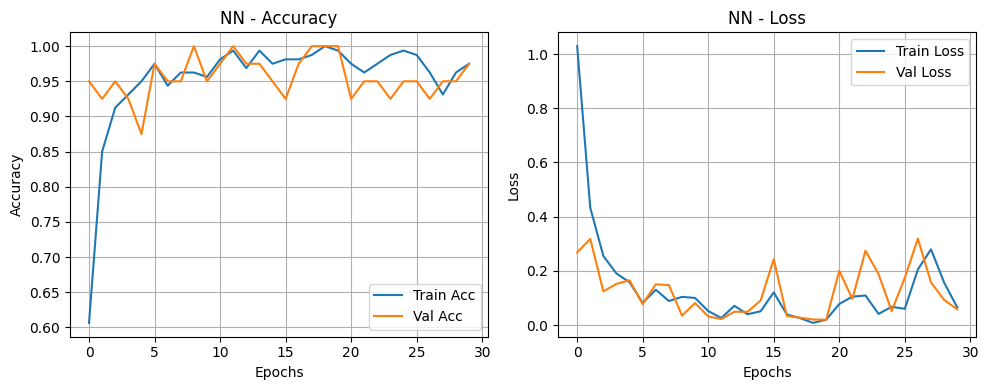

In [37]:
plot_training_history(history_nn, "NN")


NN - Evaluation Results
Test Accuracy: 96.00%

Classification Report:
              precision    recall  f1-score   support

    celinguk     1.0000    0.8000    0.8889        10
        diam     0.8333    1.0000    0.9091        10
      nodong     1.0000    1.0000    1.0000        10
   tutupmuka     1.0000    1.0000    1.0000        10
 tutuptangan     1.0000    1.0000    1.0000        10

    accuracy                         0.9600        50
   macro avg     0.9667    0.9600    0.9596        50
weighted avg     0.9667    0.9600    0.9596        50



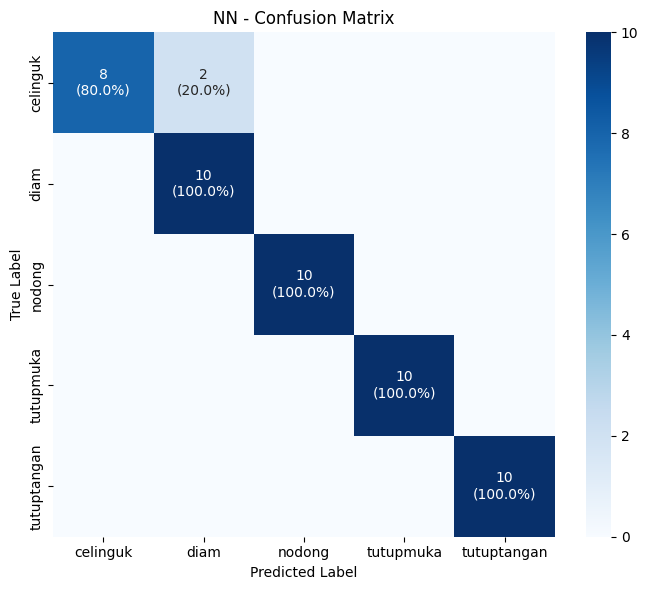

In [38]:
evaluate_model(nn_model, X_test, y_test, "NN")